In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
from utils.isomaxplus import IsoMaxPlusLossFirstPart, IsoMaxPlusLossSecondPart

from utils.misc import fix_random_seed
fix_random_seed(0)

In [3]:
import torch
import torchvision
from torch import nn

import numpy as np


def init_model(_ckpt_path, num_classes=2, _model=None, device='cuda'):
    """The backbone is frozen so we only load it once"""
    if _model is None:
        ckpt = torch.load(_ckpt_path, map_location="cpu")
        _model = torchvision.models.resnet50()
        backbone = torch.nn.Sequential(*list(_model.children())[:-1])
        emb_dim = _model.fc.in_features
        head = IsoMaxPlusLossFirstPart(emb_dim, num_classes)

        _model = nn.Sequential(backbone, nn.Flatten(), head)
        _model.load_state_dict(ckpt, strict=False)
        _model.emb_dim = emb_dim
    else:
        assert hasattr(_model, "emb_dim")
        _model[-1] = IsoMaxPlusLossFirstPart(_model.emb_dim, num_classes)
    _model.to(device)
    return _model


def get_pre_extracted_features(_ckpt_dir: str, _set_name: str) -> np.ndarray:
    pre_extracted_feats = np.load(f'{_ckpt_dir}/feats_{_set_name}.npy', mmap_mode='r')
    pre_extracted_feats = ((pre_extracted_feats - pre_extracted_feats.mean(axis=1, keepdims=True)) /
                           pre_extracted_feats.std(axis=1, keepdims=True))
    return pre_extracted_feats

In [4]:
from utils import datasets as dsets
from torch.utils.data import DataLoader

stage = 1
trn_split = 'va'
train_attr = 'yes'
worst_metric = 'wga_val'
subsample_type = 'group'
dataset_name = 'Waterbirds'
data_dir = '/scratch/ssd004/scratch/minht/datasets/'
ckpt_path = '/scratch/ssd004/scratch/minht/checkpoints/sd0/Waterbirds/13574640/'

workers = 6
batch_size_train, batch_size_eval = 256, 256

datasets, dataloaders = dict(), dict()
datasets['val'] = vars(dsets)[dataset_name](data_dir, 'va', None)
datasets['test'] = vars(dsets)[dataset_name](data_dir, 'te', None)

trn_split = 'va'
for set_name in ['val', 'test']:
    datasets[set_name].feats = get_pre_extracted_features(ckpt_path, set_name)
    dataloaders[set_name] = DataLoader(dataset=datasets[set_name], num_workers=workers, pin_memory=False,
                                       batch_size=batch_size_eval, shuffle=False)

def get_train_loader():
    datasets['train'] = vars(dsets)[dataset_name](
        data_dir, trn_split, None, train_attr=train_attr, subsample_type=subsample_type, stage=stage,
        pre_extracted_feats=datasets['val'].feats)
    train_loader = DataLoader(datasets['train'], batch_size=batch_size_train, drop_last=True, shuffle=True, num_workers=workers, pin_memory=False)
    return train_loader

In [5]:
from tqdm import tqdm

from utils.eval_helpers import eval_metrics, get_acc


def evaluate_epoch(_model, eval_loader, device='cuda'):
    ds = eval_loader.dataset
    classes, attributes, groups = np.array(ds.y), np.array(ds._a), np.array(ds.g)
    _model.eval()
    all_preds = []
    with torch.no_grad():
        for *_, feats in eval_loader:
            feats = feats.to(device)
            outputs = _model[-1](feats)
            all_preds.append(outputs.detach().softmax(1).cpu())
        all_preds = torch.concat(all_preds, dim=0).numpy()
        _res = eval_metrics(all_preds, np.array(classes), np.array(attributes), np.array(groups))
    return _res['min_group']['accuracy']


def evaluate_ensemble(_prototype_ensemble, eval_loader, _model, device='cuda', show_individuals=False):
    dist_scales = [_[1].detach() for _ in _prototype_ensemble]
    clf = torch.concat([_[0] for _ in _prototype_ensemble], dim=1).detach().transpose(0, 1)
    preds_list = torch.zeros(clf.shape[0], len(eval_loader.dataset), eval_loader.dataset.num_labels)

    ds = eval_loader.dataset
    classes, attributes, groups = np.array(ds.y), np.array(ds._a), np.array(ds.g)

    position = 0

    with torch.no_grad():
        for *_, feats in tqdm(eval_loader, leave=False):
            feats = feats.to(device)

            for i, _weight in enumerate(clf):
                _model[-1].prototypes = torch.nn.Parameter(_weight, requires_grad=False)
                _model[-1].distance_scale = nn.Parameter(dist_scales[i], requires_grad=False)
                _model.eval()
                preds_list[i][position:position + feats.shape[0]] = _model[-1](feats.squeeze())
            position += feats.shape[0]

    if show_individuals:
        for i in range(preds_list.shape[0] - 1, -1, -1):
            preds = preds_list[i].softmax(1).argmax(1).numpy()
            get_acc(preds, classes, groups)

    get_acc(preds_list.softmax(2).mean(0).argmax(1).numpy(), classes, groups)

    preds = preds_list.softmax(2).mean(0).detach().cpu().numpy()
    _res = eval_metrics(preds, classes, attributes, groups)
    return _res


def train_prototypes(train_loader, model, _prototype_ensemble=(),
                     epochs=20, cov_reg=5e5, wd_weight=10, device='cuda', entropic=30, lr=1e-3, _stage=1):
    best_val_wga, val_wga = 0.0, 0.0
    best_val_wga_prototype = None

    criterion = IsoMaxPlusLossSecondPart(entropic_scale=entropic, reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    if len(prototype_ensemble) > 0:
        _prototype_ensemble = torch.concat([_[0] for _ in _prototype_ensemble], dim=1).detach()

    for epoch in range(epochs):
        model.train()
        running_loss, running_clf, running_cov, running_correct, total = 0.0, 0.0, 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"[Stage {_stage}] Epoch {epoch + 1}", leave=False if epoch < epochs - 1 else True, )

        for _, _, labels, _, _, feats in pbar:
            feats = feats.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model[-1](feats)
            clf_loss = criterion(outputs, labels)

            head = model[-1]
            wd = torch.einsum('ijk,ilk->ijl', [head.prototypes[:, None], head.prototypes[:, None]]) * wd_weight
            wd = wd.squeeze().mean()
            loss = clf_loss + wd

            cov_loss = torch.tensor(0.0, device=device)
            if len(_prototype_ensemble) and (cov_reg > 0):
                _prototypes = torch.cat([head.prototypes[:, None], _prototype_ensemble], dim=1)
                n_pro, n_dim = _prototypes.shape[1:]
                cov = torch.einsum('ijk,ilk->ijl', [_prototypes, _prototypes]) / (n_dim - 1)
                cov_loss = torch.abs(cov[:, 0, 1:].sum(1).div(n_pro).mean())
                loss += cov_loss * cov_reg

            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            correct = (preds == labels).sum().item()
            running_loss += loss.item()
            running_clf += clf_loss.item()
            running_cov += cov_loss.item()
            running_correct += correct
            total += labels.size(0)

            pbar.set_postfix({
                'loss': running_loss / (total // labels.size(0)),
                'clf': running_clf / (total // labels.size(0)),
                'cov': running_cov / (total // labels.size(0)),
                'acc': f"{running_correct / total:.2%}",
                'val wga': f"{val_wga:.2%}"
            })

        val_wga = evaluate_epoch(model, dataloaders['val'])
        if val_wga >= best_val_wga:
            best_val_wga = val_wga
            best_val_wga_prototype = [
                model[-1].prototypes[:, None].detach().clone(),
                model[-1].distance_scale.detach().clone()
            ]

    return best_val_wga_prototype


from functools import partial

full_model = None
prototype_ensemble = []
_train_prototypes = partial(train_prototypes, epochs=20, cov_reg=5e5, wd_weight=10, device='cuda', entropic=30, lr=1e-3)
ensemble_wga, ensemble_balanced_acc = [], []

for stage in range(1, 16):
    full_model = init_model(ckpt_path + 'ckpt_last.pt', num_classes=2, _model=full_model)
    prototype_ensemble.append(_train_prototypes(
        get_train_loader(), full_model,
        _prototype_ensemble=prototype_ensemble, _stage=stage,
    ))
    res = evaluate_ensemble(prototype_ensemble, dataloaders['test'], full_model, device='cuda')
    ensemble_wga.append(res['min_group']['accuracy'])
    ensemble_balanced_acc.append(res['overall']['balanced_acc'])
    print(f"Ensemble WGA: {ensemble_wga[-1]*100:.1f}")

[Stage 1] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  8.86it/s, loss=0.111, clf=0.0478, cov=0, acc=98.63%, val wga=92.70%]


Avg ACC: 0.953
ACC per group: [0.97, 0.956, 0.916, 0.921]
Ensemble WGA: 91.6


[Stage 2] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  8.69it/s, loss=0.269, clf=0.0448, cov=2.91e-7, acc=98.44%, val wga=96.57%]


Avg ACC: 0.958
ACC per group: [0.975, 0.956, 0.931, 0.936]
Ensemble WGA: 93.1


[Stage 3] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s, loss=0.187, clf=0.0722, cov=7.18e-8, acc=98.44%, val wga=92.49%]


Avg ACC: 0.959
ACC per group: [0.98, 0.951, 0.927, 0.949]
Ensemble WGA: 92.7


[Stage 4] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  9.21it/s, loss=0.237, clf=0.114, cov=6.57e-8, acc=96.29%, val wga=90.13%] 


Avg ACC: 0.961
ACC per group: [0.981, 0.955, 0.928, 0.944]
Ensemble WGA: 92.8


[Stage 5] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  8.76it/s, loss=0.224, clf=0.115, cov=5.6e-8, acc=95.31%, val wga=87.22%]  


Avg ACC: 0.962
ACC per group: [0.981, 0.953, 0.939, 0.953]
Ensemble WGA: 93.9


[Stage 6] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s, loss=0.272, clf=0.152, cov=5.12e-8, acc=95.31%, val wga=77.25%] 


Avg ACC: 0.961
ACC per group: [0.98, 0.95, 0.941, 0.952]
Ensemble WGA: 94.1


[Stage 7] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s, loss=0.225, clf=0.117, cov=6.26e-8, acc=95.12%, val wga=86.47%]


Avg ACC: 0.960
ACC per group: [0.982, 0.945, 0.939, 0.955]
Ensemble WGA: 93.9


[Stage 8] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  9.03it/s, loss=0.259, clf=0.114, cov=1.41e-7, acc=96.48%, val wga=87.34%]


Avg ACC: 0.962
ACC per group: [0.98, 0.951, 0.944, 0.956]
Ensemble WGA: 94.4


[Stage 9] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s, loss=0.191, clf=0.101, cov=5.62e-8, acc=98.63%, val wga=91.42%]


Avg ACC: 0.961
ACC per group: [0.979, 0.949, 0.944, 0.956]
Ensemble WGA: 94.4


[Stage 10] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  8.74it/s, loss=0.203, clf=0.1, cov=1.1e-7, acc=98.63%, val wga=89.27%]    


Avg ACC: 0.960
ACC per group: [0.98, 0.946, 0.944, 0.956]
Ensemble WGA: 94.4


[Stage 11] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  8.78it/s, loss=0.205, clf=0.0834, cov=1.38e-7, acc=98.05%, val wga=89.06%]


Avg ACC: 0.960
ACC per group: [0.978, 0.947, 0.944, 0.956]
Ensemble WGA: 94.4


[Stage 12] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s, loss=0.231, clf=0.134, cov=6.6e-8, acc=96.88%, val wga=81.55%]  


Avg ACC: 0.960
ACC per group: [0.978, 0.946, 0.945, 0.955]
Ensemble WGA: 94.5


[Stage 13] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  9.33it/s, loss=0.215, clf=0.105, cov=9.39e-8, acc=97.85%, val wga=81.12%] 


Avg ACC: 0.959
ACC per group: [0.979, 0.945, 0.945, 0.953]
Ensemble WGA: 94.5


[Stage 14] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  8.64it/s, loss=0.262, clf=0.121, cov=1.65e-7, acc=95.31%, val wga=87.22%] 


Avg ACC: 0.959
ACC per group: [0.978, 0.947, 0.944, 0.953]
Ensemble WGA: 94.4


[Stage 15] Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  8.81it/s, loss=0.233, clf=0.0956, cov=1.66e-7, acc=97.46%, val wga=86.91%]


Avg ACC: 0.960
ACC per group: [0.978, 0.948, 0.944, 0.953]
Ensemble WGA: 94.4


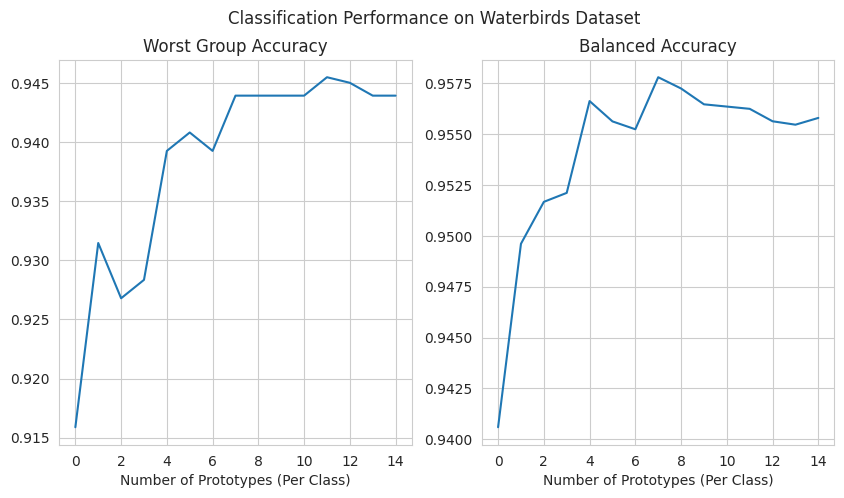

In [10]:
import pylab as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = sns.lineplot(ensemble_wga, ax=axes[0])
axes[0].set_title('Worst Group Accuracy')
axes[0].set_xlabel('Number of Prototypes (Per Class)')
_ = sns.lineplot(ensemble_balanced_acc, ax=axes[1])
axes[1].set_title('Balanced Accuracy')
plt.suptitle('Classification Performance on Waterbirds Dataset')
_ = axes[1].set_xlabel('Number of Prototypes (Per Class)')